# ENN Acme 

`enn_acme` provides tools for research in reinforcement learning based around epistemic neural networks.

This library is built upon two core pieces:
- `enn`: [github](https://github.com/deepmind/enn), [paper](https://arxiv.org/abs/2107.08924)
- `acme`: [github](https://github.com/deepmind/acme), [paper](https://arxiv.org/abs/2006.00979)

**Before moving forward with this tutorial we strongly recommend you familiarize yourself with those libraries.**

If you just want to focus on learning from code, then this is a netural progression
1. [`jax`](https://github.com/google/jax): core machine learning framework
2. [`haiku`](https://github.com/deepmind/dm-haiku): neural network library
3. [`enn`](https://github.com/deepmind/dm-haiku): epistemic neural networks in haiku.
4. [`acme`](https://github.com/deepmind/acme): high-level building blocks for RL agents
5. [`rlax`](https://github.com/deepmind/rlax): useful functions in agent development.

**This tutorial colab is meant to give you an example of piecing those underlying libraries together with `enn_acme`.**

In [ ]:
# Copyright 2022 DeepMind Technologies Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
!git clone https://github.com/deepmind/enn_acme.git
!pip install -q enn_acme/

## Imports



In [3]:
#@title General imports

from typing import Tuple


import dataclasses
import warnings

import chex
import haiku
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import plotnine as gg
import haiku as hk
import jax
import jax.numpy as jnp
import reverb
import rlax
import acme
from acme import types
from acme import specs
from acme import wrappers
from acme.jax import utils as acme_utils
from enn import base as enn_base
from enn import losses
from enn import networks
from enn import utils as enn_utils
from bsuite import bsuite
from bsuite.logging import csv_load as bsuite_csv_load

warnings.filterwarnings('ignore')

In [4]:
#@title ENN_ACME imports

import enn_acme
from enn_acme import base as agent_base
from enn_acme import agents
from enn_acme import losses as agent_losses
from enn_acme import planners
from enn_acme.losses import single_index

## High level overview

`enn_acme` is built for research with two high level concepts, outlined in `base.py`.

1. **`EnnPlanner`**: selects actions based on an ENN knowledge representation.
  - `enn`: epistemic neural network at construction
  - `select_action`: takes in parameters, observation and outputs an action.
  - `observe_first`: [optional] updates planner based on first step of environment.
  - `observe`: [optional] updates planner based on first step of the environment.

2. **`LossFn`**: defines how to process one batch of data, for one random key. This function takes:
  - `enn`: epistemic neural network.
  - `params`: parameters for knowledge representation, and for which we will take gradient steps.
  - `state`: `LearnerState`
  - `batch`: a reverb replay sample
  - `key`: a random key.

Intuitively, the `EnnPlanner` contains the code for action selection given a knowledge representation (e.g. $\epsilon$-greedy or Thompson sampling).
The `LossFn` describes how the agent updates its beliefs given observed data.

**For many research questions these should be the only pieces of code that you need to edit.**
- We provide example `EnnPlanner`s in the `planners/` folder.
- We provide example `LossFn`s in the `losses/` folder.



In [5]:
#@title Example random planner

class RandomPlanner(agent_base.EnnPlanner):
  """A planner selects actions randomly."""

  def __init__(self,
               enn: enn_base.EpistemicNetwork,
               environment_spec: specs.EnvironmentSpec,
               seed: int = 0):
    self.enn = enn
    self.num_actions = environment_spec.actions.num_values
    self.rng = hk.PRNGSequence(seed)

  def select_action(self,
                    params: hk.Params,
                    observation: enn_base.Array) -> agent_base.Action:
    """Selects an action given params and observation."""
    action = jax.random.choice(next(self.rng), self.num_actions)
    return acme_utils.to_numpy_squeeze(action)

In [6]:
#@title Example Q-learning loss forwarding a single index.

@dataclasses.dataclass
class QLearning(agent_base.LossFn):
  """Q learning loss implemented in enn_acme format."""
  discount: float = 0.99
  
  def __call__(self,
               enn: enn_base.EpistemicNetwork,
               params: hk.Params,
               state: agent_base.LearnerState,
               batch: reverb.ReplaySample,
               key: enn_base.RngKey) -> Tuple[enn_base.Array, agent_base.LossMetrics]:
    """Compute the loss on a single batch of data, for one index."""
    # Parse transitions, forward ENN index
    transitions: types.Transition = batch.data
    index = enn.indexer(key)

    # Parse q values
    net_out_tm1 = enn.apply(params, transitions.observation, index)
    q_tm1 = enn_utils.parse_net_output(net_out_tm1)
    net_out_t = enn.apply(state.target_params, transitions.next_observation, index)
    q_t = enn_utils.parse_net_output(net_out_t)

    # Return mean TD error
    d_t = (transitions.discount * self.discount).astype(jnp.float32)
    r_t = jnp.float32(transitions.reward)
    td_errors = jax.vmap(rlax.q_learning)(q_tm1, transitions.action, r_t, d_t, q_t)

    return jnp.mean(jnp.square(td_errors)), {}

## Example agent on bsuite

In this section we provide example evaluation of a benchmark agent on [`bsuite`](https://github.com/deepmind/bsuite).

> `bsuite` is a collection of carefully-designed experiments that investigate core capabilities of a reinforcement learning (RL) agent.




In [7]:
#@title  Load an environment from bsuite, and wrap it for Acme
SAVE_PATH = '/tmp/bsuite/dqn'
env = bsuite.load_and_record_to_csv('catch/0', SAVE_PATH, overwrite=True)
env = wrappers.SinglePrecisionWrapper(env)
spec = specs.make_environment_spec(env)

Loaded bsuite_id: catch/0.
Logging results to CSV file for each bsuite_id in /tmp/bsuite/dqn.


We define a simple single process agent in terms of:
- `enn`: epistemic network
- `EnnPlanner`: action selection
- `LossFn`: how to update parameters.

We will implement a simple version of "bootstrapped DQN with randomized prior functions":
- Paper: https://arxiv.org/abs/1806.03335
- Idea: Ensemble of networks, approximate Thompson sampling

In [8]:
#@title Define an ENN from the environment spec, note we need to flatten the observation for an MLP to work.
def _wrap_with_flatten(
    enn: enn_base.EpistemicNetwork) -> enn_base.EpistemicNetwork:
  """Wraps an ENN with a flattening layer."""
  flatten = lambda x: jnp.reshape(x, [x.shape[0], -1])
  return enn_base.EpistemicNetwork(
      apply=lambda p, x, z: enn.apply(p, flatten(x), z),
      init=lambda k, x, z: enn.init(k, flatten(x), z),
      indexer=enn.indexer,
  )


def make_enn(spec: specs.EnvironmentSpec) -> enn_base.EpistemicNetwork:
  """Creates appropriately sized enn from environment spec."""
  # Ensemble of size 10 with prior functions
  enn = networks.make_ensemble_mlp_with_prior_enn(
      output_sizes=[50, 50, spec.actions.num_values],
      dummy_input=jnp.ones((1,) + spec.observations.shape),
      num_ensemble=5,
      prior_scale=1,
      seed=77,
  )
  return _wrap_with_flatten(enn)

enn = make_enn(spec)

In [9]:
# Config contains standard options like optimizer
config = agents.AgentConfig(
    n_step=1,
    target_update_period=4,
    batch_size=128,
)

# Define a clipped q learning loss, averaged over 10 samples
single_loss = agent_losses.ClippedQlearning(discount=0.99)
loss_fn = agent_losses.average_single_index_loss(single_loss, 10)

# Use a thompson sampling planner.
planner = planners.ThompsonQPlanner(enn)

# Form the agent
ensemble_agent = agents.EnnAgent(
    environment_spec=spec,
    enn=enn,
    loss_fn=loss_fn,
    planner=planner,
    config=config,
)

Now we can run that agent and plot the results

In [10]:
#@title We can see that this agent does actually learn
loop = acme.EnvironmentLoop(env, ensemble_agent)
loop.run(num_episodes=500)

In [11]:
#@title We can see that bsuite automatically logged the data to csv.
!cat /tmp/bsuite/dqn/bsuite_id_-_catch-0.csv

steps,episode,total_return,episode_len,episode_return,total_regret
9,1,-1.0,9,-1.0,2.0
18,2,-2.0,9,-1.0,4.0
27,3,-3.0,9,-1.0,6.0
36,4,-4.0,9,-1.0,8.0
45,5,-5.0,9,-1.0,10.0
54,6,-6.0,9,-1.0,12.0
63,7,-7.0,9,-1.0,14.0
72,8,-8.0,9,-1.0,16.0
81,9,-9.0,9,-1.0,18.0
90,10,-8.0,9,1.0,18.0
108,12,-8.0,9,1.0,20.0
126,14,-8.0,9,-1.0,22.0
153,17,-11.0,9,-1.0,28.0
180,20,-14.0,9,-1.0,34.0
225,25,-19.0,9,-1.0,44.0
270,30,-22.0,9,-1.0,52.0
360,40,-30.0,9,-1.0,70.0
450,50,-34.0,9,-1.0,84.0
540,60,-36.0,9,-1.0,96.0
630,70,-42.0,9,-1.0,112.0
720,80,-44.0,9,-1.0,124.0
810,90,-44.0,9,-1.0,134.0
900,100,-36.0,9,1.0,136.0
1080,120,-28.0,9,1.0,148.0
1260,140,-8.0,9,1.0,148.0
1530,170,14.0,9,1.0,156.0
1800,200,44.0,9,1.0,156.0
2250,250,94.0,9,1.0,156.0
2700,300,144.0,9,1.0,156.0
3600,400,236.0,9,1.0,164.0
4500,500,336.0,9,1.0,164.0


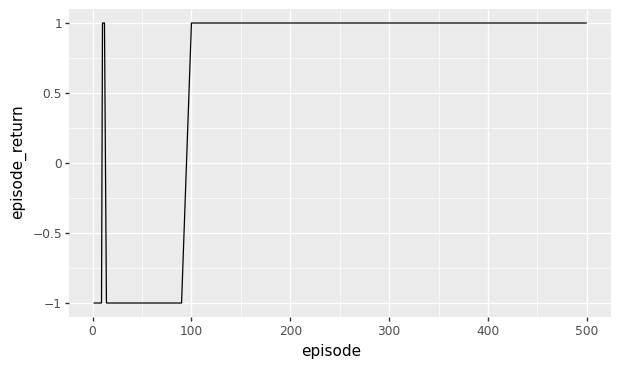

<ggplot: (8729911456729)>

In [12]:
#@title Plotting the agent performance through time... it learns to obtain optimal return of 1.
DF, _ = bsuite_csv_load.load_bsuite(SAVE_PATH)

p = (gg.ggplot(DF)
     + gg.aes(x='episode', y='episode_return')
     + gg.geom_line()
     + gg.theme(figure_size=(7, 4))
)
p

For more information on the agents, please check the source code, reach out on Github or even twitter!